In [1]:
from matplotlib import pyplot as plt

import galprime as gp

from astropy.io import fits
from astropy.table import Table

config = gp.read_config_file("myconfig.gprime")

/Users/hsouch/GalPRIME/galprime/utils/fluxes.py:8: RuntimeWarning: divide by zero encountered in log10
  sb = -2.5 * np.log10(f / (arcconv ** 2)) + m_0
/Users/hsouch/GalPRIME/galprime/utils/fluxes.py:8: RuntimeWarning: invalid value encountered in log10
  sb = -2.5 * np.log10(f / (arcconv ** 2)) + m_0


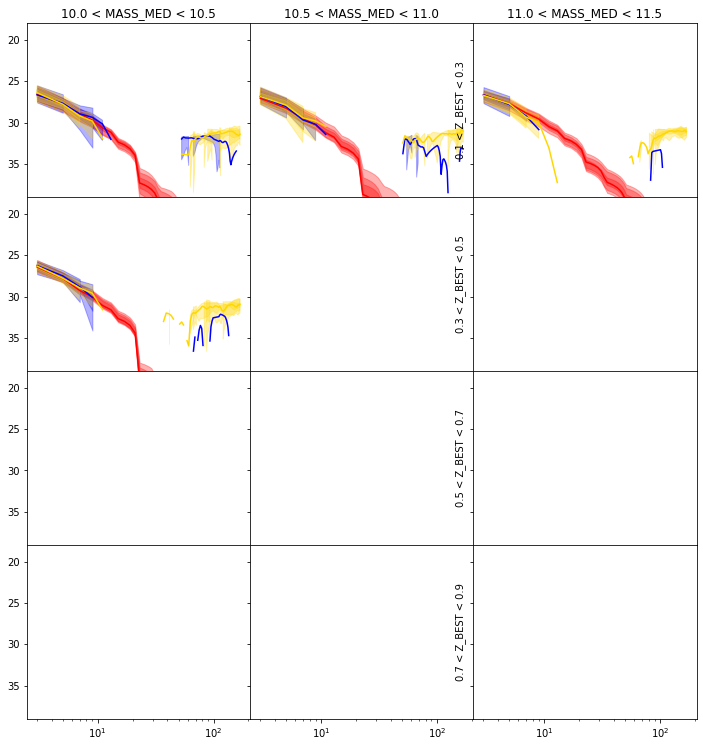

In [ ]:
def handle_bins(config):
    keys = config["BINS"].keys()
    arrs = config["BINS"].values()
    
    return keys, arrs


def filename_suffix(index_arr):
    outstr = ""
    for i in index_arr:
        outstr += f'_{i}'
    return outstr


def populate_axis(axis, filename, **kwargs):
    with fits.open(filename) as hdul:
        bare = Table.read(hdul[1])
        bgadded = Table.read(hdul[2])
        bgsub = Table.read(hdul[3])
    
    colors = kwargs.get("colors", ["red", "blue", "gold"])
    
    m_0 = config["MODEL"]["ZPM"]
    arcconv = config["MODEL"]["ARCCONV"]
    for i, tab in enumerate([bare, bgadded, bgsub]):
        axis.plot(tab["SMA"], gp.to_sb(tab["MEDIAN"], m_0=config["MODEL"]["ZPM"]), color=colors[i])
        for low, high in zip(["LOW_1SIG", "LOW_2SIG", "LOW_3SIG"], ["UP_1SIG", "UP_2SIG", "UP_3SIG"]):
            axis.fill_between(tab["SMA"], 
                              gp.to_sb(tab[low], m_0=m_0, arcconv=arcconv),
                              gp.to_sb(tab[high], m_0=m_0, arcconv=arcconv), color=colors[i], alpha=0.3)


def matrix_plot(config, run_id, x_ind=1, y_ind=0, z_ind=None, width=12, height_ratio=0.8, **kwargs):
    keys, arrs = handle_bins(config)

    x_key, x_arr = keys[x_ind], arrs[x_ind]
    y_key, y_arr = keys[y_ind], arrs[y_ind]
    nrows, ncols = len(y_arr) - 1, len(x_arr) - 1


    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           sharey=kwargs.get("sharey", True), sharex=kwargs.get("sharex", True),
                           facecolor="white",
                           figsize = (width, width * (nrows / ncols) * height_ratio))

    for i in range(len(x_arr) - 1):
        for j in range(len(y_arr) - 1):

            axis = ax[j, i]

            index_arr = [0 for _ in keys]
            index_arr[x_ind] = i
            index_arr[y_ind] = j
            if z_ind is not None:
                index_arr[z_ind[0]] = z_ind[1]

            filename = f'{config["OUTDIR"]}medians/{run_id}{filename_suffix(index_arr)}.fits'
            try:
                populate_axis(axis, filename)
            except FileNotFoundError:
                continue
            except Exception as e:
                print(e)
                continue

    for i in range(len(x_arr) - 1):
        axis = ax[0, i]
        axis.set_title(f"{x_arr[i]} < {x_key} < {x_arr[i + 1]}")
    for j in range(len(y_arr) - 1):
        axis = ax[j, -1]
        axis.set_ylabel(f"{y_arr[j]} < {y_key} < {y_arr[j + 1]}")

    plt.xscale(kwargs.get("xscale", "linear"))
    plt.ylim(kwargs.get("ylim", (39, 18)))
    plt.subplots_adjust(wspace=0, hspace=0)

    outname = kwargs.get("outname", f'{config["OUTDIR"]}')



matrix_plot(config, 11121518, width=12, z_ind=[2, 0], xscale="log")

In [8]:
class MatrixPlot:
    def __init__(self, config, run_id=0, **kwargs):
        self.config = gp.read_config_file(config) if isinstance(config, str) else config
        self.run_id = run_id

        self.x_ind=kwargs.get("x_ind", 1)
        self.y_ind=kwargs.get("y_ind", 0)

        keys, arrs = handle_bins(config, run_id)
        
    def plot(self):
        pass


class KDEPlot(MatrixPlot):
    
    def __init__(self, config, run_id=0, **kwargs):
        super().__init__(config, run_id=run_id, **kwargs)


mp = MatrixPlot(config)

kdep = KDEPlot(config)